In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, VectorIndexer
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#Libraries needed for plotting graphs
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

import pandas as pd

%matplotlib inline
rcParams['figure.figsize'] = 20, 20
plt.style.use('seaborn-whitegrid')

#Initialise the SparkSeesion

spark = SparkSession \
.builder \
.appName("customer churn example") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()

# Load and parse the data file, converting it to a DataFrame.
CV_data = spark.read.load('churn-bigml-80.csv', 
                          format='csv', 
                          header='true', 
                          inferSchema='true')

final_test_data = spark.read.load('churn-bigml-20.csv', 
                          format='csv', 
                          header='true', 
                          inferSchema='true')
CV_data.cache()
CV_data.printSchema()

root
 |-- State: string (nullable = true)
 |-- Account length: integer (nullable = true)
 |-- Area code: integer (nullable = true)
 |-- International plan: string (nullable = true)
 |-- Voice mail plan: string (nullable = true)
 |-- Number vmail messages: integer (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total day calls: integer (nullable = true)
 |-- Total day charge: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total eve calls: integer (nullable = true)
 |-- Total eve charge: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total night calls: integer (nullable = true)
 |-- Total night charge: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)
 |-- Total intl calls: integer (nullable = true)
 |-- Total intl charge: double (nullable = true)
 |-- Customer service calls: integer (nullable = true)
 |-- Churn: boolean (nullable = true)



/Users/apple/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  """


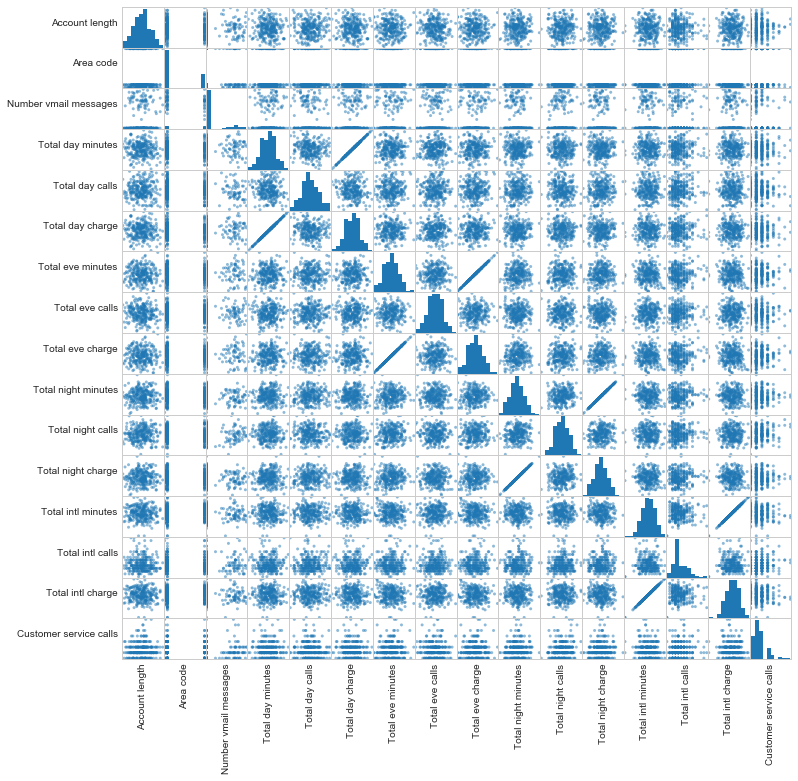

In [2]:
numeric_features = [t[0] for t in CV_data.dtypes if t[1] == 'int' or t[1] == 'double']

sampled_data = CV_data.select(numeric_features).sample(False, 0.10).toPandas()

axs = pd.scatter_matrix(sampled_data, figsize=(12, 12));

# Rotate axis labels and remove axis ticks
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

### Drop the variables that are co-related as they are useless for our model
### Convert categorical to numeric variables

In [3]:
from pyspark.ml.feature import StringIndexer

CV_data = CV_data.drop('State').drop('Area code') \
    .drop('Total day charge').drop('Total eve charge') \
    .drop('Total night charge').drop('Total intl charge')

final_test_data = final_test_data.drop('State').drop('Area code') \
    .drop('Total day charge').drop('Total eve charge') \
    .drop('Total night charge').drop('Total intl charge')

In [4]:
#convert the label to string
CV_data = CV_data.withColumn("Churn", CV_data["Churn"].cast("string"))
final_test_data = final_test_data.withColumn("Churn", final_test_data["Churn"].cast("string"))

In [5]:
#Index the labels international plan and voice mail plan for training data

indexer = StringIndexer(inputCol="International plan", outputCol="Ind International plan")
CV_data = indexer.fit(CV_data).transform(CV_data)

indexer = StringIndexer(inputCol="Voice mail plan", outputCol="Ind Voice mail plan")
CV_data = indexer.fit(CV_data).transform(CV_data)

#Index the labels international plan and voice mail plan for testing data
indexer = StringIndexer(inputCol="International plan", outputCol="Ind International plan")
final_test_data = indexer.fit(final_test_data).transform(final_test_data)

indexer = StringIndexer(inputCol="Voice mail plan", outputCol="Ind Voice mail plan")
final_test_data = indexer.fit(final_test_data).transform(final_test_data)

#drop the string columns from the database
CV_data = CV_data.drop('International plan').drop('Voice mail plan')

final_test_data = final_test_data.drop('International plan').drop('Voice mail plan')

## Implementing the Decision Tree Classifier model

In [6]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [7]:
#assembling the features in one vector = "features"
vectorAss = VectorAssembler(inputCols=["Account length",
                                       "Number vmail messages",
                                       "Total day minutes",
                                       "Total day calls",
                                      "Total eve minutes","Total eve calls","Total night minutes",
                                      "Total night calls","Total intl minutes","Total intl calls",
                                      "Customer service calls","Ind International plan","Ind Voice mail plan"]
                            ,outputCol="features")

vectorized_CV_data = vectorAss.transform(CV_data)

#assemble the features in one column = features for testing data
final_test_data = vectorAss.transform(final_test_data)

In [8]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='Churn',
                             outputCol='indexedLabel').fit(vectorized_CV_data)

# Automatically identify categorical features and index them
featureIndexer = VectorIndexer(inputCol='features',
                               outputCol='indexedFeatures',
                               maxCategories=2).fit(vectorized_CV_data)

In [9]:
# Train a DecisionTree model
dTree = DecisionTreeClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures')

In [10]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, dTree])

In [11]:
# Search through decision tree's maxDepth parameter for best model
paramGrid = ParamGridBuilder().addGrid(dTree.maxDepth, [2,3,4,5,6,7]).build()

In [12]:
# Set F-1 score as evaluation metric for best model selection
evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel',
                                              predictionCol='prediction', metricName='f1')

## Finding the best model 

In [13]:
# Set up 3-fold cross validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=3)

CV_model = crossval.fit(vectorized_CV_data)

# Fetch best model
tree_model = CV_model.bestModel.stages[2]
print (tree_model)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_4241a0c4aa04d3c95d8d) of depth 7 with 121 nodes


## Evaluating the model

In [14]:
transformed_data = CV_model.transform(final_test_data)
print (evaluator.getMetricName(), 'accuracy:', evaluator.evaluate(transformed_data))

predictions = transformed_data.select('indexedLabel', 'prediction', 'probability')
predictions.toPandas().head()

f1 accuracy: 0.9411069606506214


,indexedLabel,prediction,probability
0,0.0,0.0,"[0.9764309764309764, 0.02356902356902357]"
1,1.0,1.0,"[0.08333333333333333, 0.9166666666666666]"
2,1.0,1.0,"[0.0, 1.0]"
3,0.0,0.0,"[0.9976958525345622, 0.002304147465437788]"
4,0.0,0.0,"[0.9764309764309764, 0.02356902356902357]"


In [15]:
tp = predictions[(predictions.indexedLabel == 1) & (predictions.prediction == 1)].count()
tn = predictions[(predictions.indexedLabel == 0) & (predictions.prediction == 0)].count()
fp = predictions[(predictions.indexedLabel == 0) & (predictions.prediction == 1)].count()
fn = predictions[(predictions.indexedLabel == 1) & (predictions.prediction == 0)].count()
print ("True Positives:", tp)
print ("True Negatives:", tn)
print ("False Positives:", fp)
print ("False Negatives:", fn)
print ("Total", predictions.count())

p = float(tp) / (tp + fn)
print ("precision - true", p)

p1 = float(tn) / (tn + fp)
print ("precision - false", p1)

True Positives: 69
True Negatives: 560
False Positives: 12
False Negatives: 26
Total 667
precision - true 0.7263157894736842
precision - false 0.9790209790209791


# Trying to understand the correlations between the variables 
### Using heatmap

In [16]:
CV_heatmap = StringIndexer(inputCol='Churn',
                             outputCol='indexedLabel').fit(vectorized_CV_data).transform(vectorized_CV_data)

In [17]:
pdData = CV_heatmap.toPandas()
pdData
#corr = CV_data.corr()
#corr

,Account length,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Churn,Ind International plan,Ind Voice mail plan,features,indexedLabel
0,128,25,265.1,110,197.4,99,244.7,91,10.0,3,1,false,0.0,1.0,"[128.0, 25.0, 265.1, 110.0, 197.4, 99.0, 244.7...",0.0
1,107,26,161.6,123,195.5,103,254.4,103,13.7,3,1,false,0.0,1.0,"[107.0, 26.0, 161.6, 123.0, 195.5, 103.0, 254....",0.0
2,137,0,243.4,114,121.2,110,162.6,104,12.2,5,0,false,0.0,0.0,"[137.0, 0.0, 243.4, 114.0, 121.2, 110.0, 162.6...",0.0
3,84,0,299.4,71,61.9,88,196.9,89,6.6,7,2,false,1.0,0.0,"[84.0, 0.0, 299.4, 71.0, 61.9, 88.0, 196.9, 89...",0.0
4,75,0,166.7,113,148.3,122,186.9,121,10.1,3,3,false,1.0,0.0,"[75.0, 0.0, 166.7, 113.0, 148.3, 122.0, 186.9,...",0.0
5,118,0,223.4,98,220.6,101,203.9,118,6.3,6,0,false,1.0,0.0,"[118.0, 0.0, 223.4, 98.0, 220.6, 101.0, 203.9,...",0.0
6,121,24,218.2,88,348.5,108,212.6,118,7.5,7,3,false,0.0,1.0,"[121.0, 24.0, 218.2, 88.0, 348.5, 108.0, 212.6...",0.0
7,147,0,157.0,79,103.1,94,211.8,96,7.1,6,0,false,1.0,0.0,"[147.0, 0.0, 157.0, 79.0, 103.1, 94.0, 211.8, ...",0.0
8,141,37,258.6,84,222.0,111,326.4,97,11.2,5,0,false,1.0,1.0,"[141.0, 37.0, 258.6, 84.0, 222.0, 111.0, 326.4...",0.0
9,74,0,187.7,127,163.4,148,196.0,94,9.1,5,0,false,0.0,0.0,"[74.0, 0.0, 187.7, 127.0, 163.4, 148.0, 196.0,...",0.0


In [18]:
corr = pdData.corr()
#plotting the heat-map

#sns.heatmap(r1,xticklabels=r1.columns.values, yticklabels=r1.columns.values,linewidths=0.5)

In [19]:
corr

,Account length,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,Ind International plan,Ind Voice mail plan,indexedLabel
Account length,1.000000,-0.002996,0.002847,0.038862,-0.015923,0.018552,-0.008994,-0.024007,0.011369,0.017627,0.002455,0.024500,0.002448,0.017728
Number vmail messages,-0.002996,1.000000,0.019027,-0.009622,0.011401,0.005131,-0.000224,0.008124,-0.004156,0.027013,-0.018787,0.005858,0.957159,-0.086474
Total day minutes,0.002847,0.019027,1.000000,0.016780,0.003999,0.009059,0.013491,0.015054,-0.011042,0.005687,-0.024543,0.049550,0.013438,0.195688
Total day calls,0.038862,-0.009622,0.016780,1.000000,-0.026003,0.006473,0.008986,-0.016776,0.031036,0.006928,-0.011945,-0.004277,-0.007541,0.018290
Total eve minutes,-0.015923,0.011401,0.003999,-0.026003,1.000000,-0.007654,-0.013414,0.009017,-0.006915,0.002160,-0.013192,0.026616,0.019132,0.072906
Total eve calls,0.018552,0.005131,0.009059,0.006473,-0.007654,1.000000,-0.000175,0.000797,0.011012,0.003710,0.001058,0.010277,0.003404,-0.001539
Total night minutes,-0.008994,-0.000224,0.013491,0.008986,-0.013414,-0.000175,1.000000,0.012736,-0.008607,-0.001110,0.005236,-0.010310,0.001065,0.033639
Total night calls,-0.024007,0.008124,0.015054,-0.016776,0.009017,0.000797,0.012736,1.000000,-0.023447,0.019367,-0.005677,0.018081,0.013985,0.012262
Total intl minutes,0.011369,-0.004156,-0.011042,0.031036,-0.006915,0.011012,-0.008607,-0.023447,1.000000,0.037315,-0.002826,0.053162,-0.013963,0.086204
Total intl calls,0.017627,0.027013,0.005687,0.006928,0.002160,0.003710,-0.001110,0.019367,0.037315,1.000000,-0.022143,0.011549,0.015196,-0.069882


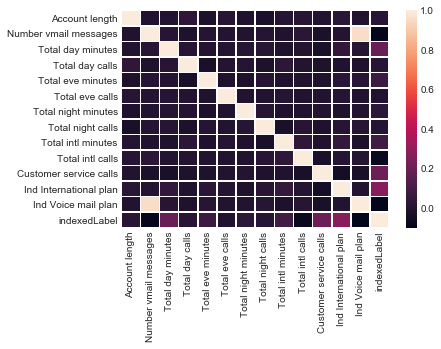

In [20]:
sns.heatmap(corr,xticklabels=corr.columns.values, yticklabels=corr.columns.values,linewidths=0.5)